In [6]:
import matplotlib.pyplot as plt
import os, re, pickle,tqdm
import scipy.io
from collections import defaultdict
import numpy as np
import warnings, logging
warnings.filterwarnings('ignore')

import pandas as pd

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def nested_dict(n):
    if n == 1:
        return defaultdict(lambda: np.ndarray(0))
    else:
        return defaultdict(lambda: nested_dict(n-1))
    
color_code = {
    "DET vs FullGradCam":       "blue",
    "DET-GrpF vs FullGradCam":  "#0072BD",
    "DET-GrpE vs FullGradCam":  "cyan",
    
    "EXP vs ODAM":              "red",
    "EXP-GrpF vs ODAM":         "orange",
    "EXP-GrpE vs ODAM":         "olive",

    "PV vs FullGradCam":        "purple",
    "PV-GrpF vs FullGradCam":   "pink",
    "PV-GrpE vs FullGradCam":   "magenta",
}

tnrfont = {'fontname':'Times New Roman'}

alpha = 0.3

In [7]:
focused_analysis = ['DET vs FullGradCam','EXP vs ODAM']
layer_name_mapping = ['model_1_act', 'model_2_cv1_act', 'model_2_cv2_act', 'model_2_m_0_cv1_act', 'model_2_m_0_cv2_act', 'model_2_cv3_act', 'model_3_act', 'model_4_cv1_act', 'model_4_cv2_act', 'model_4_m_0_cv1_act', 'model_4_m_0_cv2_act', 'model_4_m_1_cv1_act', 'model_4_m_1_cv2_act', 'model_4_cv3_act', 'model_5_act', 'model_6_cv1_act', 'model_6_cv2_act', 'model_6_m_0_cv1_act', 'model_6_m_0_cv2_act', 'model_6_m_1_cv1_act', 'model_6_m_1_cv2_act', 'model_6_m_2_cv1_act', 'model_6_m_2_cv2_act', 'model_6_cv3_act', 'model_7_act', 'model_8_cv1_act', 'model_8_cv2_act', 'model_8_m_0_cv1_act', 'model_8_m_0_cv2_act', 'model_8_cv3_act', 'model_9_cv1_act', 'model_9_cv2_act', 'model_10_act', 'model_13_cv1_act', 'model_13_cv2_act', 'model_13_m_0_cv1_act', 'model_13_m_0_cv2_act', 'model_13_cv3_act', 'model_14_act', 'model_17_cv1_act', 'model_17_cv2_act', 'model_17_m_0_cv1_act', 'model_17_m_0_cv2_act', 'model_17_cv3_act']

special_layer_start = [
    # "model_9_cv1_act" ,"model_10_act"
    ]

# cogsci_layer = [
#     'model_23_cv3_act',
#     'model_21_act',
#     'model_20_cv3_act',
#     'model_18_act',
#     'model_17_cv3_act',
#     'model_14_act',
#     'model_13_cv3_act',
#     'model_10_act',
#     'model_9_cv2_act',
#     'model_8_cv3_act',
#     'model_7_act',
#     'model_6_cv3_act',
#     'model_5_act',
#     'model_4_cv3_act',
#     'model_3_act',
#     'model_2_cv3_act',
#     'model_1_act',
# ]

cogsci_layer = []

## Clustering

In [8]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import time, pickle
import itertools
from itertools import chain

hyperparameters = {
'n_clusters': [None],
'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
'linkage': ['ward', 'complete', 'average', 'single'],
}
keys, values = zip(*hyperparameters.items())
param_grid = [(idx, dict(zip(keys, v))) for idx, v in enumerate(itertools.product(*values))]
print(len(param_grid))

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendro = dendrogram(linkage_matrix, **kwargs)

    clusters = defaultdict(list)

    for leaf_label, leaf_color in zip(dendro['ivl'],dendro['leaves_color_list']):
        clusters[leaf_color].append(leaf_label)

    return clusters

def extract_clusters_from_labels(cluster_labels, leaves):
    # Group leaves based on their cluster labels
    clusters = {}
    for leaf, label in zip(leaves, cluster_labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(leaf+1)

    return clusters

import time, sys

sys.tracebacklimit = 0

def fit_model(dfs, ax, analysis, idx, params):

    start = time.time()

    # analysis = 'EXP vs ODAM'
    # data = np.reshape(dfs[analysis].mean(axis=1),(-1, 1))
    nan_imgs = set([dfs[analysis].columns[column] for row,column in zip(*np.where(dfs[analysis].isna()))])
    if len(nan_imgs) > 0:
        print(f'{analysis} dropped {len(nan_imgs)}')
    data = dfs[analysis].drop(columns=nan_imgs) #TODO: auto detect and drop nan

    if not params['n_clusters']:
        params['distance_threshold'] = 0 # make sure we compute the full tree

    model = AgglomerativeClustering(compute_distances=True,
                                    **params
                                    )
    labels = model.fit_predict(data)
    clusters = plot_dendrogram(model, ax=ax,truncate_mode="level", labels=range(1,len(layer_name_mapping)+1))
    # ax.set_title(f"{params['metric']},{params['linkage']}")

    end = time.time()

    res = [{"analysis":analysis,
            **params,
            "labels":labels,
            "distances":model.distances_,
            "time(s)":end-start}]

    return res, clusters

cluster_labels = [
"*",
"o",
"v",
"s",
"X",
"d",
"p",
"^",
"<",
">",
"D",
"P",
"8",
"h",
]

20


## All Results

In [9]:
root_dir = '/home/jinhanz/cs/xai/results/bdd/241009_optimize_faithfulness_yolov5s_formal'

DET vs FullGradCam dropped 12
EXP vs ODAM dropped 12


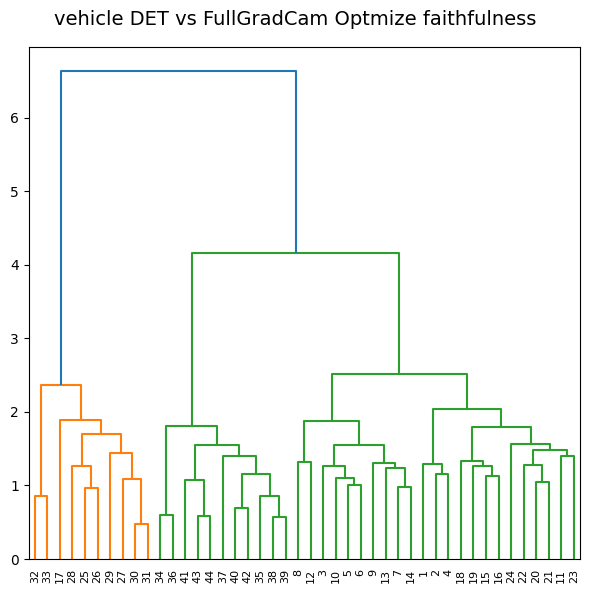

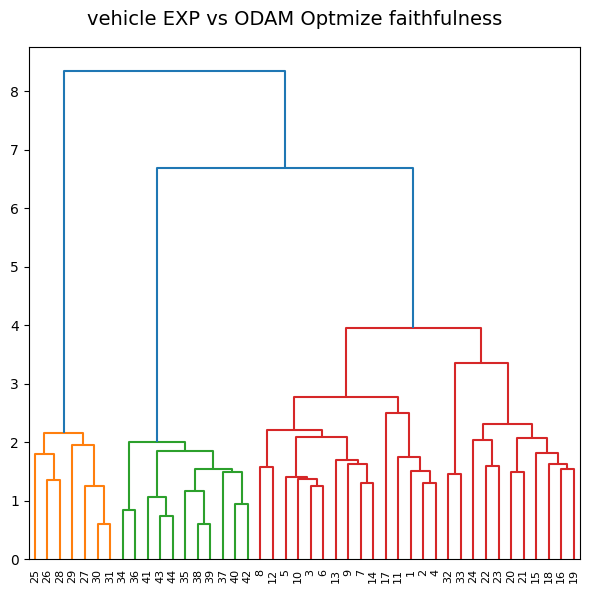

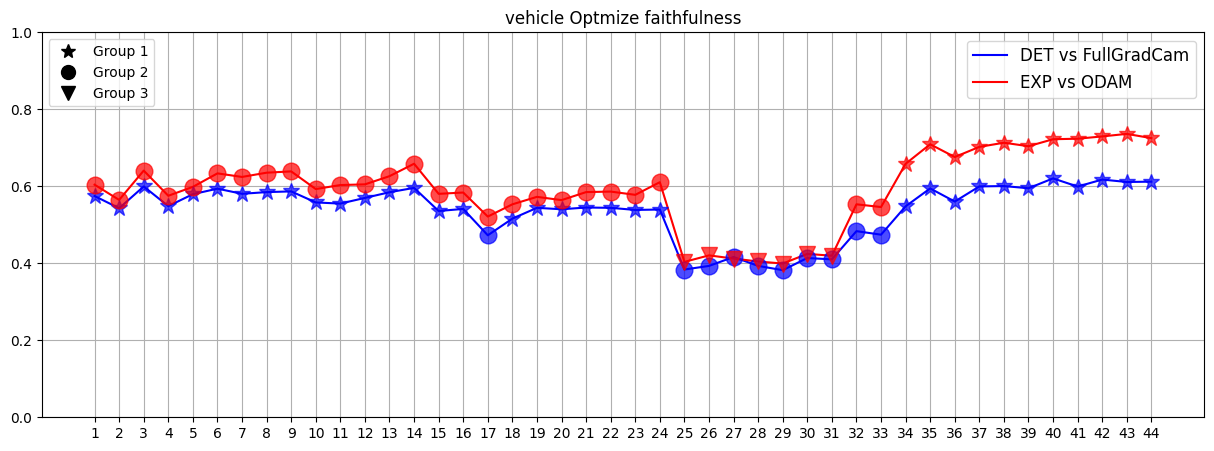

DET vs FullGradCam dropped 16
EXP vs ODAM dropped 16


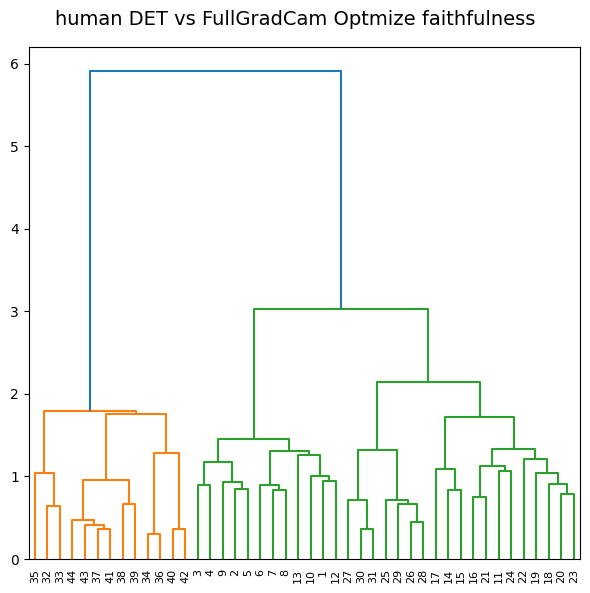

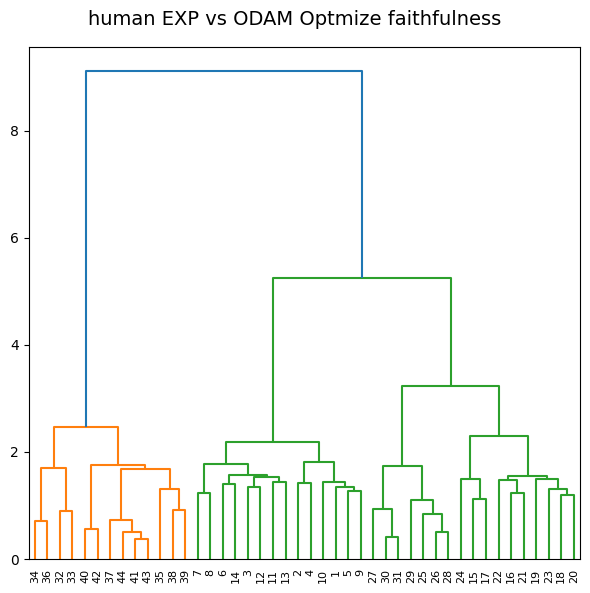

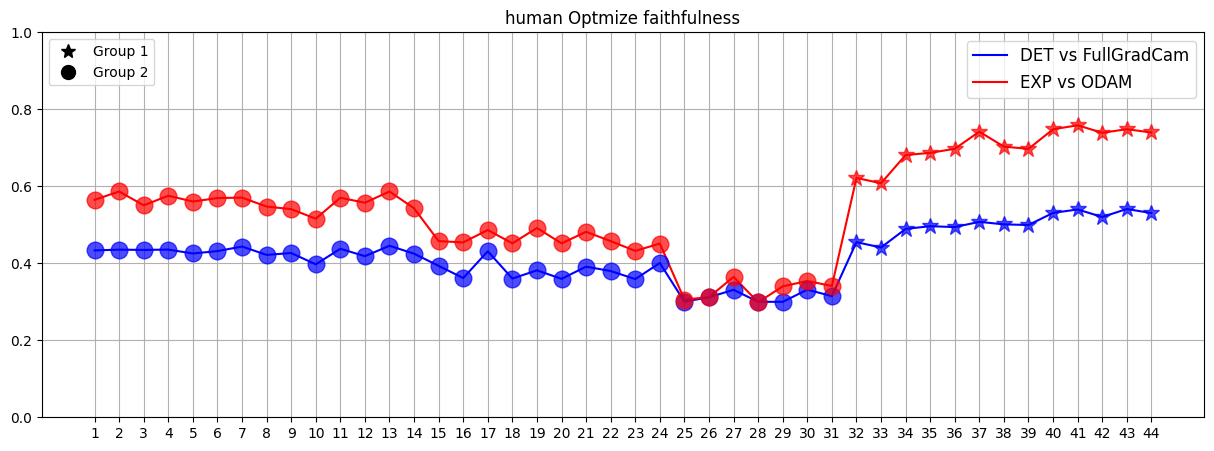

In [10]:
for object in ['vehicle','human']:
    for rescale_method in ['Optmize faithfulness']:
        PCC_all = pickle.load(open(f'{root_dir}/{object}_PCC_all_conv.pickle','rb'))
        RMSE_all = pickle.load(open(f'{root_dir}/{object}_RMSE_all_conv.pickle','rb'))

        PCC_layer_mean = defaultdict()
        RMSE_layer_mean = defaultdict()

        for analysis in PCC_all.keys():
            PCC_layer_mean[analysis] = pd.DataFrame.from_dict(PCC_all[analysis]).mean(axis=0)
            RMSE_layer_mean[analysis] = pd.DataFrame.from_dict(RMSE_all[analysis]).mean(axis=0)

        dfs = {}
        PCC_mean = {}

        # reverse layer numbering
        for analysis in focused_analysis:
            df = pd.DataFrame.from_dict(PCC_all[analysis])

            dfs[analysis] = df.T
            PCC_mean[analysis] = df.T.mean(axis=1)

            dfs[analysis].to_csv(f'{root_dir}/{object}_{rescale_method}_PCC_all_conv.csv',index=False)

        membership = defaultdict()

        for analysis in focused_analysis:
            fig, axs = plt.subplots(nrows=1, ncols=1,figsize=[6,6])
            idx = 0
            params = param_grid[0]
            res, clusters = fit_model(dfs,axs,analysis,params[0],params[1])
            membership[analysis] = clusters
            # print(clusters)
            if res != None: idx += 1
            fig.suptitle(f"{object} {analysis} {rescale_method}",fontsize=14)
            plt.tight_layout()
            plt.draw()

        import matplotlib.lines as mlines
        # Overall similarity
        plt.figure(figsize=(15, 5))
        plt.grid()
        ax = plt.gca()
        # plt.xlabel('Layer')
        # plt.ylabel('PCC')
        ylims = [0,1]
        for analysis in focused_analysis:
            plt.plot(np.arange(len(PCC_mean[analysis]))+1, list(PCC_mean[analysis]),label=analysis,c=color_code[analysis])
            plt.xticks(np.arange(len(PCC_mean[analysis]))+1, [f"{l+1}" for l,layer in enumerate(layer_name_mapping)]) #rotation=-90
            plt.ylim(ylims)
            # plt.title(f"Yolo-v5s MSCOCO")e

        # Highlight specific layers
        for tick, label in zip(ax.get_xticks(), ax.get_xticklabels()):
            if layer_name_mapping[tick-1] in cogsci_layer:
                label.set_fontweight('bold')

            if layer_name_mapping[tick-1] in special_layer_start:
                label.set_color('red')

        legend1 = plt.legend(fontsize=12, loc=0)
        ax.add_artist(legend1)

        for analysis in focused_analysis:
            # print(analysis)
            group_mean = {}
            for g, group in membership[analysis].items():
                inds = [idx-1 for idx in group]
                layers = [layer_name_mapping[idx] for idx in inds]
                mean = PCC_mean[analysis][layers].mean()
                group_mean[g] = mean
                # print(f"{g} {mean} {sorted(group)}")

            # Sort by cluster mean similarity to human attention
            group_rank = {k: rank for rank, (k, v) in enumerate(sorted(group_mean.items(), key=lambda item: item[1], reverse=True))}
            # print(group_rank)

            # print(labels[analysis])
            for g, group in membership[analysis].items():
                marker = cluster_labels[group_rank[g]]
                for l in group:
                    layer_name = layer_name_mapping[l-1]
                    plt.plot(l,PCC_mean[analysis][layer_name],marker=marker,c=color_code[analysis],markersize=12,alpha=0.7)

            # plt.plot(PCC_mean[analysis].index[12:18].values, PCC_mean[analysis].values[12:18], marker='o',fillstyle='none',label=analysis,c=color_code[analysis],alpha=alpha)

        group_markers = []
        group1_marker = mlines.Line2D([], [], color='black', marker=cluster_labels[0], linestyle='None',
                                markersize=10, label='Group 1')
        group_markers.append(group1_marker)
        group2_marker = mlines.Line2D([], [], color='black', marker=cluster_labels[1], linestyle='None',
                                markersize=10, label='Group 2')
        group_markers.append(group2_marker)

        if len([m for _, m in membership.items() if len(m)>=3])>0:
            group3_marker = mlines.Line2D([], [], color='black', marker=cluster_labels[2], linestyle='None',
                                    markersize=10, label='Group 3')
            group_markers.append(group3_marker)

        if len([m for _, m in membership.items() if len(m)>=4])>0:
            group4_marker = mlines.Line2D([], [], color='black', marker=cluster_labels[3], linestyle='None',
                                    markersize=10, label='Group 4')
            group_markers.append(group4_marker)

        legend2=plt.legend(handles=group_markers,loc=2)

        plt.title(f"{object} {rescale_method}")
        plt.show()
